In [ ]:
!pip install matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Simple utilities
def imdisp(im):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.show()

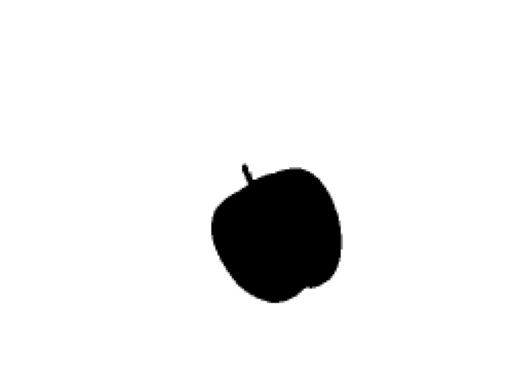

In [3]:
# Load image
image_gs = cv2.imread('frames/BadApple_400.jpg', cv2.IMREAD_GRAYSCALE)
_, image = cv2.threshold(image_gs, 127 , 255, cv2.THRESH_BINARY)
image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)
imdisp(image)

Found 1 contours with lengths [55].


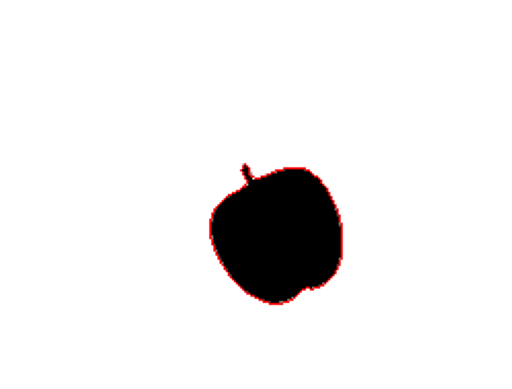

In [9]:
conts, hier = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
conts = [ i for i in conts if len(i) != 4 or [0, 0] not in i ]
print(f"Found {len(conts)} contours with lengths {[ len(i) for i in conts ]}.")
imdisp(cv2.drawContours(cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR), conts, -1, (0,0,255), 1))